# Week 5: MCMC in practice

Last week we have seen that Markov Chain Monte Carlo simulations work in theory. We can summarize our findings as follows. Given a discrete or continuous **state space** $\Gamma$, a **desired probability distribution** $\pi$ on $\Gamma$, and an **observable** $f:\Gamma \to \mathbb{R}$, the problem is to compute the expectation value of $f$ evaluated on a random variable $X$ on $\Gamma$ with probability mass function or probability density functions given by $\pi$,
$$\mathbb{E}[f(X)] = \int_\Gamma \mathrm{d}x\,\pi(x) f(x)\quad(\text{continuous}), \qquad \mathbb{E}[f(X)] = \sum_{x\in\Gamma} \pi(x) f(x)\quad(\text{discrete}).$$
In the discrete case this problem can be addressed by designing a Markov chain **transition matrix** $P(x\to y)$ that is irreducible and has $\pi$ as its **stationary distribution**, i.e. $\pi P = \pi$. One then considers the Markov chain $X_0,X_1,X_2,\ldots$ with arbitrary distribution for $X_0$ and transition probability dictated by $P(x\to y)$. The **ergodic theorem** then assures us that we can approximate $\mathbb{E}[f(X)]$ via the **time average** 
$$\frac{1}{n} \sum_{i=1}^n f(X_i) \xrightarrow[n\to\infty]{\text{almost surely}} \mathbb{E}[f(X)].$$
The same holds in the continuous case for an irreducible transition density, under a technical additional assumption of [**Harris recurrence**](https://en.wikipedia.org/wiki/Harris_chain). 

We have also seen how to obtain a suitable transition matrix $P(x\to y)$ from a proposal transition matrix $Q(x\to y)$ using the **Metropolis-Hastings algorithm**. Thus with infinite computer power, our problem of computing $\mathbb{E}[f(X)]$ is solved. In practice, however, we can only sample the time average for a finite number $n$ of states in the Markov chain, so we require quantitative control over the error $\frac{1}{n} \sum_{i=1}^n f(X_i)- \mathbb{E}[f(X)]$. In the case of **i.i.d.** random variables this error was easily related to the (estimated) variance of $f(X)$, but this becomes significantly more difficult now that the states $X_i$ are correlated.

**Warning**: There is no universally applicable recipe for performing Markov Chain Monte Carlo simulations and their error analysis! Every problem comes with its own challenges and it is our job to figure our which method works best in those circumstances. 

## A toy model: MCMC on the real line

To see where the difficulties in estimating the error come from, let us have a look at a rather artificial toy problem in which the state space is $\mathbb{R}$ and the desired distribution of the random variable $X$ displays two peaks,
$$\pi(x) = \frac{4}{5} \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} + \frac{1}{5} \frac{2}{\sqrt{2\pi}} e^{-2 (x-4)^2}.$$
Suppose we wish to estimate the expectation value of the observable $f(x)=x$, which is $\mathbb{E}[f(X)] = \mathbb{E}[X] = 4/5$, using a MCMC.

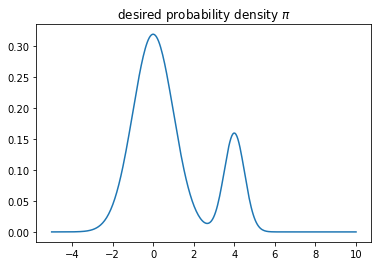

In [1]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline

def gaussian(mu,sigma,x):
    return np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))/(sigma*np.sqrt(2*np.pi))

def distribution_pi(x):
    return 0.8*gaussian(0,1,x) + 0.2*gaussian(4,0.5,x)

xrange = np.linspace(-5,10,300)
plt.plot(xrange,distribution_pi(xrange))
plt.title(r"desired probability density $\pi$")
plt.show()

To design a Markov chain $X_0,X_1,\ldots$ with the desired stationary distribution, we apply the Metropolis-Hastings acceptance to the proposal $X_i + U$ for the next state $X_{i+1}$, where $U$ is a uniform random variable in $(-\delta,\delta)$ with $\delta = 0.7$. Since $U$ has a symmetric distribution, the proposal density $q(x,y)$ is symmetric as well, and therefore the appropriate acceptance probability is $A(x\to y) = \min(1,\pi(y)/\pi(x))$ with $x=X_i$ and $y=X_i+U$. As initial state we choose a rather atypical value $X_0 = -20$. The following code samples the first 15000 steps of the Markov chain and displays plots of $X_n$ (sometimes called **traces**) for three different ranges of the time $n$, together with the estimates of $\mathbb{E}[f(X)]$ stemming from the time average in the corresponding range.

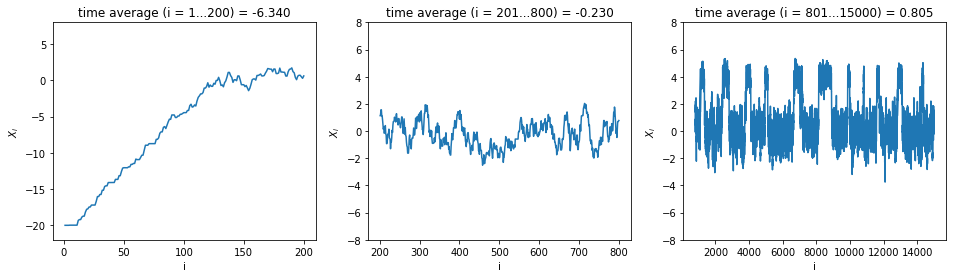

In [2]:
def MH_step(current,delta,pi):
    proposal = current + rng.uniform(-delta,delta)
    return proposal if rng.uniform() < pi(proposal)/pi(current) else current

def sample_chain(start,delta,pi,n):
    chain = np.zeros(n+1)
    chain[0] = start
    for i in range(n):
        chain[i+1] = MH_step(chain[i],delta,pi)
    return chain

delta = 0.7
start_x0 = -20
chain = sample_chain(start_x0,delta,distribution_pi,15000)
ranges = [range(1,201),range(201,801),range(801,15001)]
fig, ax = plt.subplots(1,len(ranges),figsize=(16,4))
for i in range(len(ranges)):
    ax[i].plot(ranges[i],chain[ranges[i]])
    ax[i].set_ylim(-22 if i==0 else -8,8)
    time_average = np.mean(chain[ranges[i]])
    title = "time average (i = {}...{}) = {:.3f}".format(ranges[i][0],ranges[i][-1],time_average)
    ax[i].title.set_text(title)
    ax[i].set_xlabel("i")
    ax[i].set_ylabel("$X_i$")

The first two estimates are (most likely) not particularly close to the exact value $\mathbb{E}[X]=0.8$, but for two different reasons. 

### Equilibration

It is clear that the time average $\frac{1}{n} \sum_{i=1}^n X_i$ for $n=200$ is very much biased by the atypical starting point $X_0 = -20$. This may seem artificial, since we chose deliberately to start in an atypical point, but in most applications of MCMC the situation is as bad or worse: any starting point $X_0$ we are able construct by hand in a high-dimensional sample space is almost guaranteed to be very atypical, in the sense that there are observables $f : \Gamma \to \mathbb{R}$ such that $f(X_0)$ is many sigmas away from $\mathbb{E}[f(X)]$. What we are seeing is that the probability density $f_{X_i}(x)$ for $i \leq 200$, is not yet close to the desired distribution $\pi(x)$. The time $\tau_{\mathrm{eq}}$ it takes to approach $\pi(x)$ is called the **equilibration time**, which appears to be at least $\tau_{\mathrm{eq}}\geq 200$ in this case. Of course, the contribution of the first $200$ terms to the time average $\frac{1}{n}\sum_{i=1}^n X_i$ will become negligible when $n\to\infty$, but can very much affect the estimate when $n$ is limited, because the atypical configurations $X_i$ may contribute excessive values $f(X_i)$ to the sum. A common practice is therefore to discard the first $b$ configurations in the time average, where $b$ is chosen to ensure $b\geq \tau_{\mathrm{eq}}$ to the best of our knowledge. This means that we take
$$\frac{1}{n-b}\sum_{i=b+1}^n f(X_i)$$
as our best estimate of the $\mathbb{E}[f(X)]$. The first $b$ steps in a MCMC simulation, in which we discard the observable $f(X_i)$ (and sometimes not measure $f(X_i)$ at all), is often called the **equilibration**, **thermalization**, or **burn-in** phase of the simulation. We will see a technique to gauge $\tau_{\mathrm{eq}}$ below in the case of the Ising model.

### Autocorrelation

Suppose we know for our example that at time $i\geq b=200$ the distribution of $X_i$ is already sufficiently close to $\pi(x)$. Why is our estimate based on the time average $i=201,\ldots,800$ still not great, even though we have a decent 600 data points? The reason should be intuitively clear: the states $X_i$ are far from independent, meaning that each new state only gives us a tiny bit of extra information on the distribution $\pi$. There is dependence in a trivial sense because our Markov chain is setup such that $|X_{i+1} - X_i| < \delta$, so the chain cannot wander far in a few steps. More serious is that the distribution $\pi$ has two peaks, in the vicinity of which the Markov chain likes to stay, separated by a barrier where $\pi(x)$ is very small. This means that it takes a sequence of probabilistically unlikely steps for the chain to transition between the two regions, so it happens only rarely. The dependence in this example therefore persists over a large number of steps, e.g. you can imagine from looking at the plot that when $X_i$ is in the vicinity of the first peak the probability that $X_{i+200}$ is also in this vicinity is larger than if $X_i$ was in the vicinity of the second peak, i.e. $\mathbb{P}(X_{i+200} \in (3,5) | X_{i} = 4)$ is significantly larger than $\mathbb{P}(X_{i+200} \in (3,5) | X_{i} = 0)$. For a good approximation of the desired distribution $\pi$ we need many transitions between the two regions to have occurred, showing the necessity of performing many steps in the Markov chain (the last plot shows $\pm 20$ transitions in the first 15000 steps).

Let us try to get a quantitative grasp on the error. To this end we assume that $X_0$ has exactly the stationary distribution $\pi(x)$ (perhaps obtained by performing equilibration for a long time $b$ and then resetting the label $i$ of the state $X_i$ to $0$). By construction of the stationary distribution, the same holds for all $X_i$ with $i\geq 0$. In this case $\overline{f(X)}_n=\frac{1}{n}\sum_{i=1}^n f(X_i)$ is an unbiased estimator for $\mathbb{E}[f(X)]$ since 
$$\mathbb{E}[\overline{f(X)}_n] = \frac{1}{n} \sum_{i=1}^n \mathbb{E}[f(X)] = \mathbb{E}[f(X)].$$
For the variance we have
$$\begin{align*}
\operatorname{Var}\left(\overline{f(X)}_n\right) &= \mathbb{E}\left[\left(\overline{f(X)}_n- \mathbb{E}[f(X)]\right)^2\right] \\
& = \frac{1}{n^2}\sum_{i=1}^n\sum_{j=1}^n\mathbb{E}\left[(f(X_i)-\mathbb{E}[f(X)])(f(X_j)-\mathbb{E}[f(X)])\right]\\
& = \frac{1}{n^2}\sum_{i=1}^n\left(\mathbb{E}\left[(f(X_i)-\mathbb{E}[f(X)])^2\right] + 2\sum_{t=1}^{n-i}\mathbb{E}\Big[(f(X_i)-\mathbb{E}[f(X)])(f(X_{i+t})-\mathbb{E}[f(X)])\Big]\right)\\
& = \frac{\operatorname{Var}(f(X))}{n}\left( 1 + 2 \sum_{t=1}^{n-1} \frac{n-t}{n}\rho(t)\right),\tag{1}
\end{align*}$$
where $\rho(t)$ is the **autocorrelation**
$$ 
\rho(t)=\operatorname{Corr}(f(X_i),f(X_{i+t})) := \frac{\mathbb{E}\Big[(f(X_i)-\mathbb{E}[f(X)])(f(X_{i+t})-\mathbb{E}[f(X)])\Big]}{\operatorname{Var}[f(X)]}.$$
We can estimate the latter via the **sample autocovariance**,
$$ \bar{\gamma}(t) = \frac{1}{n} \sum_{i=1}^{n-t}(f(X_i) - \overline{f(X)}_n)(f(X_{i+t}) - \overline{f(X)}_n),$$
from which one obtains the **sample autocorrelation** as $$\bar{\rho}(t) = \frac{\bar{\gamma}(t)}{\bar{\gamma}(0)}$$
by normalizing $\bar{\gamma}(t)$ by the sample variance $\bar{\gamma}(0)$.
Note that there is a $1/n$ factor in front of the sum in $\bar{\gamma}(t)$, while one may instead expect an $1/(n-t)$ since there are $n-t$ terms. The reason is that this choice is often found to be more stable numerically. 

One may be tempted to take the sample autocorrelation $\bar{\rho}(t)$ and plug it in (1), to get an error estimate. However, in practice this rarely works, because the statistical errors in $\bar{\rho}(t)$ grow large when $t$ becomes of the order of $n$. It is often more convenient to estimate an **autocorrelation time** $\tau_f$ under the assumption that $\bar{\rho}(t)$ decays exponentially, i.e. $\bar{\rho}(t)\approx e^{-t/\tau_f}$. This can be done either by fitting an exponential curve or, slightly less accurately, by taking $\tau_f$ to be the first time $t$ that $\bar{\rho}(t)$ drops below $1/e$,
$$\tau_f \approx \inf\{t : \bar{\rho}(t) < 1/e\}.$$
If $1 \ll \tau_f \ll n$, then 
$$\left( 1 + 2 \sum_{t=1}^{n-1} \frac{n-t}{n}\bar{\rho}(t)\right)\approx 2\sum_{t=1}^\infty e^{-t/\tau_f} \approx 2\tau_f.$$
Therefore a rough $1\sigma$-estimate becomes
$$ \mathbb{E}[f(X)] = \overline{f(X)}_n \pm \sqrt{\frac{2 \tau_{f}}{n} \,\bar{\gamma}(0)}.$$
Intuitively, we can understand this result in comparison with the **i.i.d.**-case, where the $2\tau_f$ factor was missing from the square root. Averaging over $f(X_i)$ over all times $i=1,2,\ldots,n$ is essentially as good as averaging $f(X_i)$ at times $i=0,2\tau_f,4\tau_f,\ldots$. In the latter case the samples are almost independent, but we have only $n/(2\tau_f)$ of them. The values that were skipped were sufficiently correlated that they did not contribute much to the accuracy of the average. Therefore the error is as if we were looking at a sequence of $n/(2\tau_f)$ i.i.d. samples.

autocorrelation time = 158
E[X] = 0.458 +- 0.131


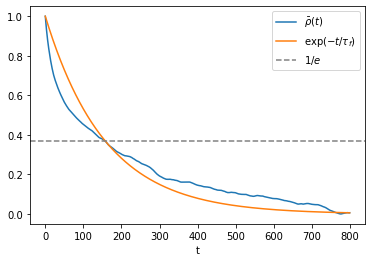

In [3]:
def sample_autocovariance(x,tmax):
    '''Compute the autocorrelation of the time series x for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/len(x) for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than autocov[0]/e.'''
    return np.where(autocov < np.exp(-1)*autocov[0])[0][0]
    
tmax = 800
burnin = 1000
chain = sample_chain(0,delta,distribution_pi,50000)[burnin:]
autocov = sample_autocovariance(chain,tmax)
autocorr_time = find_correlation_time(autocov)
print("autocorrelation time =",autocorr_time)
error = np.sqrt(2*autocorr_time*autocov[0]/len(chain))
print("E[X] = {:.3f} +- {:.3f}".format(np.mean(chain),error))

plt.plot(autocov/autocov[0])
plt.plot(np.exp(-np.arange(tmax)/autocorr_time))
plt.axhline(np.exp(-1),linestyle='--',color='0.5')
plt.xlabel("t")
plt.legend([r"$\bar{\rho}(t)$",r"$\exp(-t / \tau_f)$",r"$1/e$"])
plt.show()

By running the above code several times, you will notice that the error is in the right ballpark, but is perhaps not as accurate and stable as you would like. In order to arrive at the error we had to make several assumptions and approximations that necessarily introduce systematic biases in the error estimate. Most notably $\hat{\rho}(t)$ is not necessarily well-approximated by an exponential decay $e^{-t/\tau_f}$, even in the limit of large $n$. We will see more robust and versatile error analysis methods later. Nevertheless, it is almost always a good idea when attacking a problem with MCMC to quickly get an order-of-magnitude estimate of the correlation time $\tau_f$ of the observable $f:\Gamma \to \mathbb{R}$ of interest, for two reasons:
* You get an order-of-magnitude estimate of the number $n$ of Markov chain steps needed to reach a desired accuracy.
* If measuring the observable $f(X_i)$ on a given configuration $X_i$ is computationally expensive, you could choose to perform on the order of $\tau_f$ steps in between measurements without increasing the error much. This is called **thinning** (see below).

## MCMC simulation of the 2D Ising model

Let us return to the more interesting ferromagnetic Ising model on a 2D lattice of size $w\times w=N$. We have seen last week how to design a Markov chain on $\Gamma = \{-1,1\}^N$ that approaches the desired Boltzmann distribution
$$ \pi(s) = \frac{1}{Z} e^{-\beta H(s)}, \qquad H(s) = - J \sum_{i\sim j}s_is_j,\qquad s\equiv(s_1,\ldots,s_N)\in \{-1,1\}^N.$$
Since $J$ and $\beta$ only appear in the combination $J\beta$ and we will only consider the ferromagnetic case $J>0$, we will set $J=1$ in the following for convenience.
At each step of the Markov chain a uniform random site $i$ is selected and a flip $s_i \to s_i'=-s_i$ is proposed. We derived that the appropriate Metropolis-Hastings acceptance probability of this move $s\to s'$ is
$$ A(s\to s') = \min(1,e^{-\beta \Delta H}), \qquad \Delta H(s) = 2 s_i \sum_{j:\, i\sim j} s_j.$$
A natural observable is the **magnetization** $M(s) = \sum_{i=1}^N s_i$ and its normalized version, the **magnetization per spin** $m(s) = M(s)/N$. However, it is easy to see that $\mathbb{E}[M(s)] = 0$ due to the symmetry of the two spin states $\pm 1$:
$$ \pi(-s) = \pi(s), \quad \text{while}\quad M(-s) = - M(s) \quad\implies\quad \mathbb{E}[M(s)] = \sum_{s\in\Gamma} \pi(s) M(s) = 0.$$
So it is better to consider the **absolute magnetization** $|M(s)|$. We can easily figure out the behaviour in the low- and high-temperature limit.
In the limit $\beta \to \infty$ (or $T\to 0$) the only two states with positive probability $\pi(x)$ are the two completely aligned states, hence $\mathbb{E}[|m(s)|] = 1$. When $\beta = 0$ (or $T\to\infty$) the distribution $\pi(x)$ is uniform on all spin states. The difference between the number of $+1$ and $-1$ spins is then of the order $\sqrt{N}$, so $\mathbb{E}[|m(s)|] \approx N^{-1/2}$ is very small for decent size lattices.
Another natural observable is the **energy** $H(s)$ itself, which, up to normalization, counts the number of aligned nearest neighbor pairs in the configuration $s$.
Our goal will be to estimate the mean (absolute) magnetization $\mathbb{E}[|M(s)|]$ and mean energy $\mathbb{E}[H(s)]$ for a range of different temperatures. Preferably we would like to vary the lattice size as well, but for now we will concentrate on a fixed size $N = 20\times 20=400$.

### Equilibration

As we have seen in the toy problem above, it is important as a first step to get a rough idea of the equilibration time. It is customary to measure equilibration times (and other times in the simulation) not in units of individual Markov chain transitions, but in **sweeps**:
$$ 1\text{ sweep} = N\text{ Markov chain transitions} = \text{"one attempted spin flip per site on average"}.$$
So let us have a look at the traces of $M(s)$ and $H(s)$ for three different initial configurations: the uniformly random configuration; a completely aligned configuration; and the completely anti-aligned configuration.

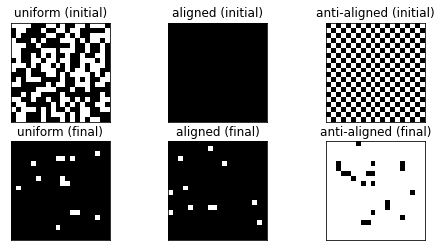

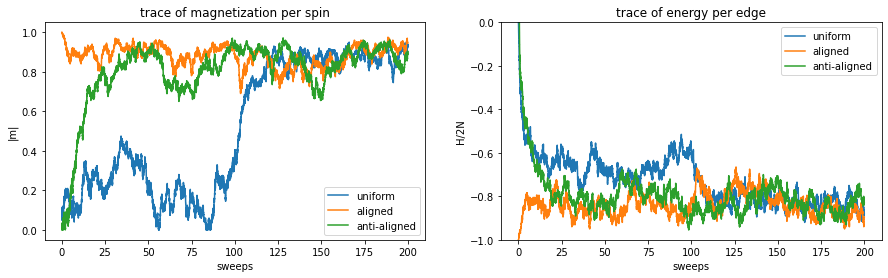

In [4]:
def attempt_spin_flip_for_trace(config,boltzmannfactor):
    '''Perform Metropolis-Hastings transition on config and return change in magnetization and energy.'''
    w = len(config)
    i,j = rng.integers(0,w,2)
    neighbour_sum = config[i,j] * (config[(i+1)%w,j] + config[(i-1)%w,j] + 
                                   config[i,(j+1)%w] + config[i,(j-1)%w])
    if neighbour_sum <= 0 or rng.random() < boltzmannfactor**neighbour_sum:
        config[i,j] = -config[i,j]
        return 2*config[i,j], 2*neighbour_sum
    else:
        return 0, 0
    
def compute_energy(config):
    '''Compute the energy H(s) of the state config (with J=1).'''
    h = 0
    w = len(config)
    for i in range(w):
        for j in range(w):
            h -= config[i,j] * (config[i,(j+1)%w] + config[(i+1)%w,j])
    return h

def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)
        
def get_MCMC_trace(config,beta,n):
    '''Sample first n steps of the Markov chain and produce trace of magnetization and energy.'''
    boltz = np.exp(-2*beta)
    trace = np.zeros((n,2))
    # set the initial magnetization and energy ...
    m = compute_magnetization(config)
    h = compute_energy(config)
    for i in range(n):
        dm, dh = attempt_spin_flip_for_trace(config,boltz)
        # ... and update them after each transition
        m += dm
        h += dh
        trace[i][0] = m
        trace[i][1] = h
    return trace

def uniform_init_config(width):
    '''Produce a uniform random configuration.'''
    return 2*rng.integers(2,size=(width,width))-1

def aligned_init_config(width):
    '''Produce an all +1 configuration.'''
    return np.ones((width,width),dtype=int)

def antialigned_init_config(width):
    '''Produce a checkerboard configuration'''
    if width % 2 == 0:
        return np.tile([[1,-1],[-1,1]],(width//2,width//2))
    else:
        return np.tile([[1,-1],[-1,1]],((width+1)//2,(width+1)//2))[:width,:width]

def plot_ising(config,ax,title):
    '''Plot the configuration.'''
    ax.matshow(config, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
# set parameters
beta = 0.48
width = 20
sweeps = 200
nsites = width * width
length = sweeps * nsites
initializers = [uniform_init_config, aligned_init_config, antialigned_init_config]
labels = ["uniform","aligned","anti-aligned"]

# produce the traces and plot initial and final configurations
traces = []
fig, ax = plt.subplots(2,3,figsize=(8,4))
for i, init in enumerate(initializers):
    config = init(width)
    plot_ising(config,ax[0][i],labels[i] + " (initial)")
    traces.append(get_MCMC_trace(config,beta,length))
    plot_ising(config,ax[1][i],labels[i] + " (final)")
plt.show()
    
# plot magnetization traces
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(length)/nsites
for i in range(3):
    ax1.plot(xrange,np.abs(traces[i][:,0]/nsites))
ax1.legend(labels)
ax1.set_xlabel("sweeps")
ax1.set_ylabel("|m|")
ax1.title.set_text("trace of magnetization per spin")

# plot energy traces
for i in range(3):
    ax2.plot(xrange,traces[i][:,1]/(2*nsites))
ax2.legend(labels)
ax2.set_xlabel("sweeps")
ax2.set_ylabel("H/2N")
ax2.set_ylim(-1,0)
ax2.title.set_text("trace of energy per edge")
plt.show()

In equilibrium, i.e. when the Markov chain has approached the stationary distribution, the three curves should be close together, or at least fluctuating within the same interval. The equilibration time $\tau_{\mathrm{eq}}$ is therefore at least as large as the time it takes for the traces to meet each other. Judging from the plot $\tau_{\mathrm{eq}} \gtrsim 150\text{ sweeps}$. Note also that the magnetization appears to take longer to reach equilibrium. This is a general phenomenon: in principle we should look at a large collection of observables and wait until all traces have suitable converged to conclude on the equilibration time. In practice, however, if it is the magnetization $|m|$ we wish to estimate, it is typically regarded to be sufficient that its own trace displays equilibrium. To be safe, it is a good idea to spend a number of sweeps in the equilibration phase that is a multiple of the suspected equilibration time $\tau_{\mathrm{eq}}$. In this case we choose to equilibrate with 500 sweeps.

### Autocorrelation

Next we need an order of magnitude estimate of the autocorrelation time.

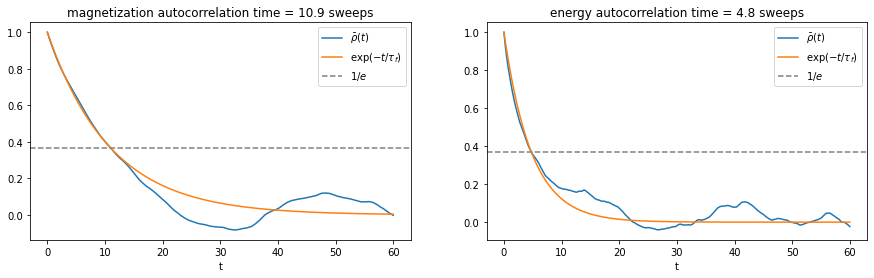

In [5]:
# gather the required trace
equil_sweeps = 500
autocorr_sweeps = 800
length = nsites * (equil_sweeps + autocorr_sweeps)
config = uniform_init_config(width)
trace = get_MCMC_trace(config,beta,length)[nsites * equil_sweeps:]

# compute the autocorrelation over a time difference of 60 sweeps
tmax = nsites * 60
fig, ax = plt.subplots(1,2,figsize=(15,4))
for i in range(2):
    autocov = sample_autocovariance(trace[:,i],tmax)
    autocorr_time = find_correlation_time(autocov)
    ax[i].plot(np.arange(tmax)/nsites,autocov/autocov[0])
    ax[i].plot(np.arange(tmax)/nsites,np.exp(-np.arange(tmax)/autocorr_time))
    ax[i].axhline(np.exp(-1),linestyle='--',color='0.5')
    ax[i].set_xlabel("t")
    ax[i].title.set_text("{} autocorrelation time = {:.1f} sweeps"
                         .format(["magnetization","energy"][i],autocorr_time/nsites))
    ax[i].legend([r"$\bar{\rho}(t)$",r"$\exp(-t / \tau_{f})$",r"$1/e$"])
plt.show()

### Thinning

We see that for this particular temperature the autocorrelation time is of the order of several sweeps. We could go ahead to estimate the mean magnetization from the trace and calculate the error from the sample variance and autocorrelation time. Instead, let us use the estimate to perform **thinning**: we re-run the simulation with a larger number of sweeps, but this time we only perform a measurement every $m$ sweeps. We choose $m$ between $1$ and $\tau_{H}$, say $m=2$. Why? Taking $m \gtrsim \tau_H$ would be wasteful, because the energy values are already largely uncorrelated after such a time interval. An advantage of thinning is that we do not need to keep track of the observables at every Markov step, saving computation time. However, this means that we have to compute the magnetization and energy every time we wish to measure it, which requires visiting all $N$ sites. This will take about the same order of time as performing $N$ transitions, i.e. $1$ sweep. A good rule of thumb is not to spend more than half of the simulation time on measurements, implying that we should take $m \gtrsim 1$. Let's gather some data with the choice $m=2$.

In [6]:
def attempt_spin_flip(config,boltzmannfactor):
    '''Perform Metropolis-Hastings transition on config.'''
    w = len(config)
    i,j = rng.integers(0,w,2)
    neighbour_sum = config[i,j] * (config[(i+1)%w,j] + config[(i-1)%w,j] + 
                                   config[i,(j+1)%w] + config[i,(j-1)%w])
    if neighbour_sum <= 0 or rng.random() < boltzmannfactor**neighbour_sum:
        config[i,j] = -config[i,j]

def run_ising_MCMC(config,beta,n):
    '''Perform n steps of the MH Markov chain on config.'''
    boltz = np.exp(-2*beta)
    for _ in range(n):
        attempt_spin_flip(config,boltz)

equil_sweeps = 500
measure_sweeps = 2
num_measurements = 600

# equilibration phase
config = uniform_init_config(width)
run_ising_MCMC(config,beta,equil_sweeps * nsites)

# measurement phase
magnetizations = np.zeros(num_measurements)
energies = np.zeros(num_measurements)
for i in range(num_measurements):
    run_ising_MCMC(config,beta,measure_sweeps * nsites)
    magnetizations[i] = compute_magnetization(config)
    energies[i] = compute_energy(config)
    
print("estimated mean magnetization per site =", np.mean(np.abs(magnetizations))/nsites)
print("estimated mean energy per edge =", np.mean(energies)/(2*nsites))

estimated mean magnetization per site = 0.8776666666666667
estimated mean energy per edge = -0.8393250000000001


Suppose we do not quite trust our estimate of the autocorrelation time or we wish to estimate a quantity that is not directly an expectation value but can be computed from the samples, like the **magnetic susceptibility**
$$\chi := \beta N \operatorname{Var}(m) = \beta N(\mathbb{E}[m^2]-\mathbb{E}[m]^2),$$
then how can we estimate the error? If we had enough computing resources and patience we would repeat the whole experiment $k\approx 20$ times independently, compute the desired quantity $k$ times, and determine the mean and standard error for the resulting i.i.d. random outcomes. Sometimes this is a good way to go, for instance when the equilibration time is very short. Quite often though one would like to base estimates on a single long run of the MCMC. Luckily there are several statistical tricks available that allows us to use a single batch of data many in order to mimic the repetition of a whole experiment, including **batching** and **resampling**.

### Batching

Batching is a very simple technique to mimic $k$ repetitions of the experiment, simply by chopping the data set into $k\approx 20$ equal size parts. The desired quantity is computed for each batch independently and the outcomes are treated as i.i.d. random variables, for which we know how to estimate the mean and standard error. This procedure is justified when the batch size $n/k$ is much larger than the autocorrelation time $\tau_f$, because then most of the measurements in one batch are uncorrelated with those in another batch.

In [7]:
def batch_estimate(data,observable,num_batches):
    batch_size = len(data)//num_batches
    values = [observable(data[i*batch_size:(i+1)*batch_size]) for i in range(num_batches)]
    return np.mean(values), np.std(values)/np.sqrt(num_batches-1)

num_batches = 10
magnet_est = batch_estimate(np.abs(magnetizations)/nsites,lambda x: np.mean(x), num_batches)
suscep_est = batch_estimate(magnetizations/nsites,lambda x: beta*nsites*np.var(x), num_batches)
print("mean magnetization: E[|m|] = {:.4f} +- {:.4f}".format(*magnet_est))
print("magnetic susceptibility: chi = {:.4f} +- {:.4f}".format(*suscep_est))

mean magnetization: E[|m|] = 0.8777 +- 0.0079
magnetic susceptibility: chi = 0.5820 +- 0.0971


### Resampling

Batching works well for estimating expectation values, but can become inaccurate for more elaborate quantities, because the batch size may not be sufficiently large. Already for the magnetic susceptibility the estimate and error can be seen to be not very accurate, as you can see by repeating the above code. In such a case resampling may offer a good alternative. When **resampling** data, we take the data that we have already gathered, like the array `magnetizations` above and "simulate" the repetition of the experiment, without actually rerunning the MCMC. One of the simplest resampling methods is called **bootstrap**. If the original measurements were given by $\{m_1,m_2,\ldots,m_n\}$, then the bootstrap resampling is given by $\{m_{i_1},m_{i_2},\ldots,m_{i_n}\}$ where $i_1,\ldots,i_n$ are independent uniform integers in $1,\ldots,n$. In words: a new data set of the same size $n$ is randomly sampled from the original with repetitions allowed. For each resampling we can compute the desired quantity $f$, and the assumption is that the standard deviation of these quantities approaches the error when the number of resamplings becomes large. Often this gives already a good estimate of the error. However, if there is serious autocorrelation in the data, it can underestimate the error. For this several refined resampling methods have been designed. In the function below we use the **stationary bootstrap** which takes a parameter $p\in[0,1]$ and does not resample every measurement individually but assembles the resample from subsequences of typical length $1/p$ of the original data. The standard bootstrap corresponds to $p=1$, while taking $1/p$ to be of the order of the autocorrelation time results in more accurate errors.

In [8]:
def resample(samples,p=1):
    if p==1:
        return rng.choice(samples,len(samples))
    n = len(samples)
    resamples = []
    index = rng.integers(n)
    for i in range(n):
        index = rng.integers(n) if rng.random() < p else (index+1)%n
        resamples.append(samples[index])
    return resamples

def bootstrap_estimate(data,observable,num=100,p=1):
    measurements = [observable(resample(data,p)) for _ in range(num)]
    return np.mean(measurements), np.std(measurements)

magnet_est_p1 = bootstrap_estimate(np.abs(magnetizations)/nsites,lambda x: np.mean(x))
suscep_est_p1 = bootstrap_estimate(magnetizations/nsites,lambda x: beta*nsites*np.var(x))
print("mean magnetization (p=1):     E[|m|] = {:.4f} +- {:.4f}".format(*magnet_est_p1))
print("magnetic susceptibility (p=1):   chi = {:.4f} +- {:.4f}".format(*suscep_est_p1))

magnet_est_p01 = bootstrap_estimate(np.abs(magnetizations)/nsites,lambda x: np.mean(x),p=0.1)
suscep_est_p01 = bootstrap_estimate(magnetizations/nsites,lambda x: beta*nsites*np.var(x),p=0.1)
print("mean magnetization (p=0.1):   E[|m|] = {:.4f} +- {:.4f}".format(*magnet_est_p01))
print("magnetic susceptibility (p=0.1): chi = {:.4f} +- {:.4f}".format(*suscep_est_p01))

mean magnetization (p=1):     E[|m|] = 0.8777 +- 0.0023
magnetic susceptibility (p=1):   chi = 0.6903 +- 0.0450
mean magnetization (p=0.1):   E[|m|] = 0.8779 +- 0.0067
magnetic susceptibility (p=0.1): chi = 0.6980 +- 0.1058


### Further reading

Toy problem is adapted from: Section 11.5 of [Art B. Owen, *Monte Carlo theory, methods and examples* (2013)](https://statweb.stanford.edu/~owen/mc/).

Ising model simulation in practice: Chapter 4 of Newman & Barkema, Monte Carlo Methods in Statistical Physics, New York, USA (1999). (See in particular Section 3.4 about the error analysis)

Article on stationary bootstrap: Politis, Dimitris N., and Joseph P. Romano. "The stationary bootstrap." Journal of the American Statistical association 89, no. 428 (1994): 1303-1313.